In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/news_gt'
output_folder = '/content/drive/MyDrive/dataset'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if os.path.exists(folder_path):
    files = os.listdir(folder_path)

    cleaned_files = [os.path.splitext(file)[0].replace('_gt_ocr', '') for file in files]
    cleaned_files.sort()

    test_files = cleaned_files[:720]
    validation_files = cleaned_files[720:1440]
    train_files = cleaned_files[1440:3600]

    def save_list(file_list, file_name):
        with open(os.path.join(output_folder, file_name), 'w') as f:
            for i, item in enumerate(file_list):
                if i < len(file_list) - 1:
                    f.write(item + ",\n")
                else:
                    f.write(item + "\n")

    save_list(test_files, 'test_files.txt')
    save_list(validation_files, 'validation_files.txt')
    save_list(train_files, 'train_files.txt')

    print("File lists saved successfully in folder 'dataset'")
else:
    print("The specified folder was not found.")

In [ ]:
!pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/225.8 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
import os

In [ ]:
model = YOLO('/content/drive/MyDrive/yolov8n.pt')

#Creating the labels

In [ ]:
from PIL import Image
import json

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

def read_filenames_from_txt(file_path):
    with open(file_path, 'r') as file:
        filenames = [line.strip().rstrip(',') for line in file if line.strip()]
    return filenames


In [ ]:
import os

label_list = [
    'NOME', 'CPF', 'PERMISSÃO', 'ACC', 'CAT. HAB.',
    '1ª HABILITAÇÃO', 'VALIDADE', 'Nº REGISTRO', 'VÁLIDA EM TODO', 'DATA NASCIMENTO',
    'DOC. IDENTIDADE/ÓRG EMISSOR/UF', 'DOC. IDENTIDADE/ÓRG EMISSOR UF', 'DOC IDENTIDADE/ÓRG EMISSOR/UF', 'FILIAÇÃO'
]

def checkClass(name):
    if name == '1ª HABILITAÇÃO':
        return 0
    elif name == 'CAT. HAB.':
        return 1
    elif name == 'CPF':
        return 2
    elif name == 'DATA NASCIMENTO':
        return 3
    elif name == 'DOC. IDENTIDADE/ÓRG EMISSOR/UF' or name == 'DOC. IDENTIDADE/ÓRG EMISSOR UF' or name == 'DOC IDENTIDADE/ÓRG EMISSOR/UF':
        return 4
    elif name == 'FILIAÇÃO':
        return 5
    elif name == 'Nº REGISTRO':
        return 6
    elif name == 'NOME':
        return 7
    elif name == 'VALIDADE':
        return 8
    elif name == 'VÁLIDA EM TODO':
        return 9
    elif name == 'PERMISSÃO':
        return 10
    elif name == 'ACC':
        return 11
    else:
        return -1

def read_gt_file(filename):
    filepath = os.path.join(path_gt, f"{filename}_gt_ocr.txt")
    gt = []
    imagepath = os.path.join(image_gt, f"{filename}_in.jpg")
    image_width, image_height = get_image_dimensions(imagepath)

    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    current_label_id = -1
    permission_texts = []

    for line in lines:
        if line.startswith('['):
            continue
        parts = line.strip().split(',', 4)
        if len(parts) == 5:
            try:
                transcription = parts[4].strip()
                x_min = int(parts[0].strip('[').strip())
                y_min = int(parts[1].strip())
                width = int(parts[2].strip())
                height = int(parts[3].strip())

                x_max = x_min + width
                y_max = y_min + height

                if transcription == 'PERMISSÃO':
                    permission_texts.append((x_min, y_min, width, height, transcription, y_max))
                else:
                    new_label_id = checkClass(transcription)
                    if new_label_id != -1:
                        current_label_id = new_label_id
                    elif current_label_id != -1:
                        # Normalization
                        x_center = (x_min + x_max) / 2 / image_width
                        y_center = (y_min + y_max) / 2 / image_height
                        norm_width = width / image_width
                        norm_height = height / image_height

                        gt.append(f"{current_label_id} {x_center} {y_center} {norm_width} {norm_height}")

            except ValueError:
                print(f"Line in {filepath} is malformed: {line.strip()}")

    # Find the PERMISSION transcript with the largest y_max
    if permission_texts:
        permission_texts.sort(key=lambda x: x[5], reverse=True)  # Sort by y_max descending
        top_permission = permission_texts[0]
        x_min, y_min, width, height, transcription, y_max = top_permission

        # Normalization for PERMISSION
        x_max = x_min + width
        y_center = (y_min + y_max) / 2 / image_height
        x_center = (x_min + x_max) / 2 / image_width
        norm_width = width / image_width
        norm_height = height / image_height

        gt.append(f"10 {x_center} {y_center} {norm_width} {norm_height}")

    return gt

def save_intersections(output_filepath, intersections):
    with open(output_filepath, 'w') as outfile:
        for line in intersections:
            outfile.write(f"{line}\n")

list_file_path = '/content/drive/MyDrive/dataset/train_files.txt'
path_gt = '/content/drive/MyDrive/news_gt'
image_gt = '/content/drive/MyDrive/BD/BID Dataset/CNH_Frente'
output_base_path = '/content/drive/MyDrive/dataset/labels/train'

filenames = read_filenames_from_txt(list_file_path)

for filename in filenames:
    gt = read_gt_file(filename)

    output_folder = os.path.join(output_base_path)
    os.makedirs(output_folder, exist_ok=True)

    output_filepath = os.path.join(output_folder, f"{filename}_in.txt")
    save_intersections(output_filepath, gt)

    print(f"File saved in: {output_filepath}")


#Checking if the labels have the correct coordinates




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
def plot_boxes(image_path, gt_path):
    # Get the dimensions of the image
    image_width, image_height = get_image_dimensions(image_path)

    # Open the image
    img = Image.open(image_path)

    # Create the figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Reads data from labels
    data = read_filenames_from_txt(gt_path)

    for item in data:
        parts = item.strip().split()
        try:
            class_id = float(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
        except ValueError as e:
            print(f"Error converting values: {e}, Line: {item.strip()}")
            continue

        # Convert normalized coordinates to pixel coordinates
        x_min = (x_center - width / 2) * image_width
        y_min = (y_center - height / 2) * image_height
        x_max = (x_center + width / 2) * image_width
        y_max = (y_center + height / 2) * image_height

        # Add rectangle to axis
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add text with class id
        ax.text(x_min, y_min - 10, f'Class {int(class_id)}', color='red', fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()

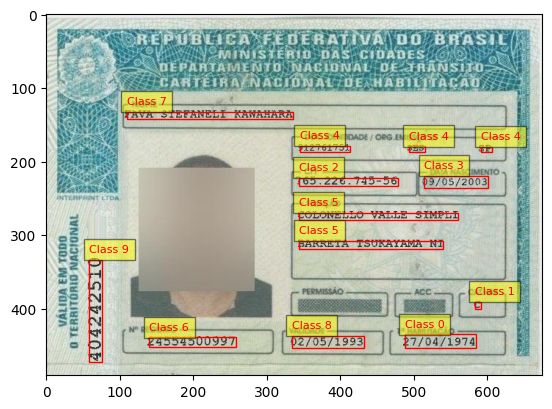

In [ ]:
filepath = '/content/drive/MyDrive/dataset/labels/test/00003604_in.txt'
image_path = '/content/drive/MyDrive/BD/BID Dataset/CNH_Frente/00003604_in.jpg'
plot_boxes(image_path, filepath)

In [ ]:
import shutil
import os

def copy_images(list_file_path, image_gt, output_base_path):
    filenames = read_filenames_from_txt(list_file_path)

    for filename in filenames:
        # Format the image file name
        image_filename = f"{filename}_in.jpg"
        src_image_path = os.path.join(image_gt, image_filename)
        dst_image_path = os.path.join(output_base_path, image_filename)

        # Check if image file exists before copying
        if os.path.isfile(src_image_path):
            shutil.copy(src_image_path, dst_image_path)
            print(f"Image copied: {src_image_path} -> {dst_image_path}")
        else:
            print(f"Image not found: {src_image_path}")

# Directory paths
list_file_path = '/content/drive/MyDrive/dataset/train_files.txt'
image_gt = '/content/drive/MyDrive/BD/BID Dataset/CNH_Frente'
output_base_path = '/content/drive/MyDrive/dataset/images/train'

# Create output directory if it does not exist
os.makedirs(output_base_path, exist_ok=True)

# Copy the images
copy_images(list_file_path, image_gt, output_base_path)


# **Training**

In [ ]:
!yolo train data=/content/drive/MyDrive/dataset/dataset.yaml model=/content/drive/MyDrive/yolov8n.pt epochs=40 --cache

WARNING ⚠️ argument '--cache' does not require leading dashes '--', updating to 'cache'.
Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/yolov8n.pt, data=/content/drive/MyDrive/dataset/dataset.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

In [ ]:
!cp /content/runs/detect/train2/weights/best.pt /content/drive/MyDrive/dataset/

# Testing with the test set

running inference on 00004211_in.jpg

image 1/1 /content/drive/MyDrive/dataset/images/test/00003604_in.jpg: 480x640 1 1_habilitacao, 1 categoria, 1 cpf, 1 d_nascimento, 3 doc_ident-emissor-ufs, 2 filiacaos, 1 n_registro, 1 nome, 1 validade, 1 espelho, 380.5ms
Speed: 22.5ms preprocess, 380.5ms inference, 38.8ms postprocess per image at shape (1, 3, 480, 640)


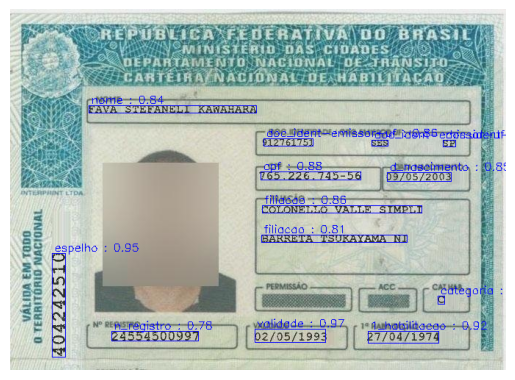

In [ ]:
model = YOLO('/content/drive/MyDrive/dataset/best.pt')
import cv2
import matplotlib.pyplot as plt
import random

def plot_bboxes(results):
    img = results[0].orig_img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    names = results[0].names
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    for score, cls, bbox in zip(scores, classes, boxes):
        class_label = names[int(cls)]
        label = f"{class_label} : {score:0.2f}"
        lbl_margin = 3

        # Draw the rectangle of bounding box
        img = cv2.rectangle(img, (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            color=(0, 0, 255),
                            thickness=1)

        # Get the text size for the label
        label_size, _ = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                        fontScale=0.5, thickness=1)
        lbl_w, lbl_h = label_size

        # Draws the label text
        cv2.putText(img, label, (bbox[0] + lbl_margin, bbox[1] - lbl_margin),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.5, color=(0, 0, 255),
                    thickness=1)
    return img

test_set_loc = '/content/drive/MyDrive/dataset/images/test/'

random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

results = model(test_set_loc + '00003604_in.jpg', conf=0.5, iou=0.1)
img = plot_bboxes(results)
plt.imshow(img)
plt.axis('off')
plt.show()

# **Create reference**

In [ ]:
import os

label_list = [
    'NOME', 'CPF', 'PERMISSÃO', 'ACC', 'CAT. HAB.',
    '1ª HABILITAÇÃO', 'VALIDADE', 'Nº REGISTRO', 'VÁLIDA EM TODO', 'DATA NASCIMENTO',
    'DOC. IDENTIDADE/ÓRG EMISSOR/UF', 'DOC. IDENTIDADE/ÓRG EMISSOR UF', 'DOC IDENTIDADE/ÓRG EMISSOR/UF', 'FILIAÇÃO'
]

def checkClass(name):
    if name == '1ª HABILITAÇÃO':
        return 0
    elif name == 'CAT. HAB.':
        return 1
    elif name == 'CPF':
        return 2
    elif name == 'DATA NASCIMENTO':
        return 3
    elif name == 'DOC. IDENTIDADE/ÓRG EMISSOR/UF' or name == 'DOC. IDENTIDADE/ÓRG EMISSOR UF' or name == 'DOC IDENTIDADE/ÓRG EMISSOR/UF':
        return 4
    elif name == 'FILIAÇÃO':
        return 5
    elif name == 'Nº REGISTRO':
        return 6
    elif name == 'NOME':
        return 7
    elif name == 'VALIDADE':
        return 8
    elif name == 'VÁLIDA EM TODO':
        return 9
    elif name == 'PERMISSÃO':
        return 10
    elif name == 'ACC':
        return 11
    else:
        return -1

def read_gt_file(filename):
    filepath = os.path.join(path_gt, f"{filename}_gt_ocr.txt")
    gt = []
    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    current_label_id = -1
    permission_texts = []

    for line in lines:
        if line.startswith('['):
            continue
        parts = line.strip().split(',', 4)
        if len(parts) == 5:
            try:
                transcription = parts[4].strip()
                x_min = int(parts[0].strip('[').strip())
                y_min = int(parts[1].strip())
                width = int(parts[2].strip())
                height = int(parts[3].strip())

                y_max = y_min + height

                if transcription == 'PERMISSÃO':
                    permission_texts.append((x_min, y_min, width, height, transcription, y_max))
                else:
                    new_label_id = checkClass(transcription)
                    if new_label_id != -1:
                        current_label_id = new_label_id
                    elif current_label_id != -1:
                        gt.append(f"{current_label_id} {transcription}")

            except ValueError:
                print(f"Line in {filepath} is malformed: {line.strip()}")

    # Find the PERMISSION transcript with the largest y_max
    if permission_texts:
        permission_texts.sort(key=lambda x: x[5], reverse=True)  # Sort by y_max descending
        top_permission = permission_texts[0]
        x_min, y_min, width, height, transcription, y_max = top_permission

        gt.append(f"10 {transcription}")

    return gt

def save_intersections(output_filepath, intersections):
    with open(output_filepath, 'w') as outfile:
        for line in intersections:
            outfile.write(f"{line}\n")

list_file_path = '/content/drive/MyDrive/dataset/test_files.txt'
path_gt = '/content/drive/MyDrive/news_gt'
image_gt = '/content/drive/MyDrive/BD/BID Dataset/CNH_Frente'
output_base_path = '/content/drive/MyDrive/reference'

filenames = read_filenames_from_txt(list_file_path)

for filename in filenames:
    gt = read_gt_file(filename)

    output_folder = os.path.join(output_base_path)
    os.makedirs(output_folder, exist_ok=True)

    output_filepath = os.path.join(output_folder, f"{filename}_in.txt")
    save_intersections(output_filepath, gt)

    print(f"File saved in: {output_filepath}")
